In [83]:
path = "../results/agnews/qwen/CAPO/seed43/benchmark_experiment_agnews_qwen_CAPO_43/d68fc10ed5808b22bcc05bf52807a08e381e40af3e141ec4bcd12359f96161a9/step_results_eval_QWEN_PFUSCH.csv"

In [84]:
import matplotlib.pyplot as plt
import pandas as pd

In [85]:
df = pd.read_csv(path)
df

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,test_score
0,1,2025-03-16 07:01:55.630194,301.327093,0.831282,You are a news categorization system. Read the...,1361,452,480697,42249,0.620
1,1,2025-03-16 07:01:55.630194,301.327093,0.820717,Determine the appropriate category for the fol...,1361,452,480697,42249,0.820
2,1,2025-03-16 07:01:55.630194,301.327093,0.806828,We're building a news classifier and need your...,1361,452,480697,42249,0.690
3,1,2025-03-16 07:01:55.630194,301.327093,0.792056,News article classification task: Categorize t...,1361,452,480697,42249,0.735
4,1,2025-03-16 07:01:55.630194,301.327093,0.762513,Classify this news article into one of these c...,1361,452,480697,42249,0.705
...,...,...,...,...,...,...,...,...,...,...
1219,102,2025-03-16 08:51:01.063419,52.118718,0.860670,"For this task, you will serve as a news catego...",1743,705,72023,4376,0.625
1220,102,2025-03-16 08:51:01.063419,52.118718,0.860514,"For this assignment, you need to carefully ana...",1743,705,72023,4376,0.675
1221,102,2025-03-16 08:51:01.063419,52.118718,0.860202,"For this task, you will serve as a news catego...",1743,705,72023,4376,0.710
1222,102,2025-03-16 08:51:01.063419,52.118718,0.860202,"For this assignment, you'll act as a news clas...",1743,705,72023,4376,0.635


In [86]:
df["total_tokens"] = (
    df["output_tokens_meta_llm"]
    + df["input_tokens_meta_llm"]
    + df["output_tokens_downstream_llm"]
    + df["input_tokens_downstream_llm"]
)
df["total_tokens"] = df["total_tokens"].cumsum()

In [87]:
# cum of tokens
df["output_tokens_downstream_llm_cum"] = df["output_tokens_downstream_llm"].cumsum()
df["output_tokens_meta_llm_cum"] = df["output_tokens_meta_llm"].cumsum()
df["input_tokens_downstream_llm_cum"] = df["input_tokens_downstream_llm"].cumsum()
df["input_tokens_meta_llm_cum"] = df["input_tokens_meta_llm"].cumsum()

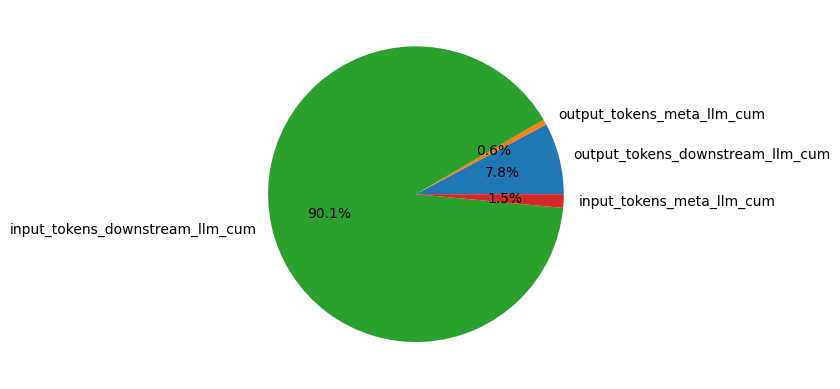

In [88]:
# plot pie
fig, ax = plt.subplots()
ax.pie(
    [
        df["output_tokens_downstream_llm_cum"].iloc[-1],
        df["output_tokens_meta_llm_cum"].iloc[-1],
        df["input_tokens_downstream_llm_cum"].iloc[-1],
        df["input_tokens_meta_llm_cum"].iloc[-1],
    ],
    labels=[
        "output_tokens_downstream_llm_cum",
        "output_tokens_meta_llm_cum",
        "input_tokens_downstream_llm_cum",
        "input_tokens_meta_llm_cum",
    ],
    autopct="%1.1f%%",
)
plt.show()

In [89]:
df["n_shots"] = df["prompt"].str.count("Input:") - 1

In [90]:
df["prompt_len"] = df["prompt"].str.len()

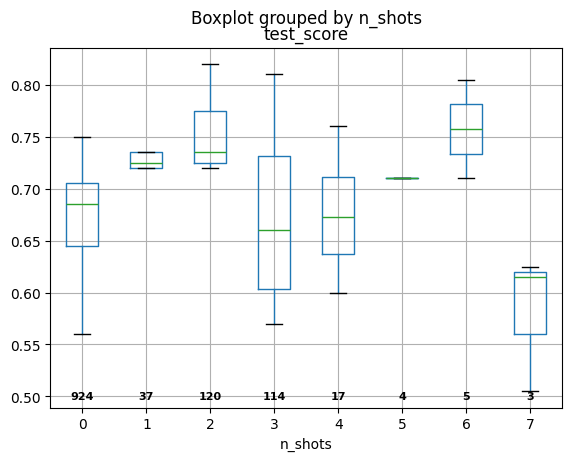

In [91]:
# correlation between number shots and score => boxplot, and give number of samples per n_shots
fig = df.groupby("prompt").first().boxplot(column="test_score", by="n_shots", showfliers=False)
# add number of samples per n_shots
num_samples = df.groupby("n_shots").size()
for i, n in enumerate(num_samples):
    fig.text(
        i + 1,
        0.5,
        n,
        ha="center",
        va="center",
        rotation=0,
        fontsize=8,
        color="black",
        fontweight="bold",
    )

plt.show();

In [92]:
# group df by step and get the mean of the values (ignore stings)
df_grouped = df.groupby("step", as_index=False).mean(numeric_only=True)
# df_grouped["cum_input_tokens"] = df_grouped["input_tokens_downstream_llm"].cumsum()

# join the maximum score for each step
df_grouped = df_grouped.join(
    df.groupby("step", as_index=False).max()[["step", "score"]].set_index("step"),
    on="step",
    rsuffix="_max",
)

df_grouped

,step,time_elapsed,score,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,test_score,total_tokens,output_tokens_downstream_llm_cum,output_tokens_meta_llm_cum,input_tokens_downstream_llm_cum,input_tokens_meta_llm_cum,n_shots,prompt_len,score_max
0,1,301.327093,0.699474,1361.0,452.0,480697.0,42249.0,0.675833,3410933.5,274618.5,2938.0,3124530.5,8846.5,3.750000,1342.333333,0.831282
1,2,434.617500,0.712170,1329.0,460.0,830672.0,88861.0,0.710833,12285701.0,1084584.5,8414.0,11167732.0,24970.5,2.750000,1026.583333,0.795405
2,3,144.994443,0.728174,1446.0,482.0,244187.0,14164.0,0.708333,19044785.5,1665386.0,14077.0,17323643.5,41679.0,2.583333,1004.916667,0.798972
3,4,64.994762,0.794286,1505.0,585.0,99647.0,8945.0,0.697917,21195753.0,1801430.5,20530.5,19314377.5,59414.5,1.666667,725.166667,0.835016
4,5,147.342124,0.770935,1546.0,617.0,242952.0,16958.0,0.696667,23507978.5,1960855.0,27758.5,21441624.0,77741.0,1.583333,709.000000,0.802695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,98,41.994841,0.862292,1674.0,651.0,65255.0,4396.0,0.702083,129768468.0,10189430.0,745903.5,116947517.5,1885617.0,0.250000,481.666667,0.879128
98,99,34.806467,0.824792,1746.0,715.0,48801.0,4049.0,0.702083,130523857.5,10239926.5,754131.5,117623626.5,1906173.0,0.250000,481.666667,0.844003
99,100,37.791627,0.862292,1649.0,607.0,58869.0,4713.0,0.702083,131256015.0,10292830.5,762009.5,118274680.5,1926494.5,0.250000,481.666667,0.879128
100,101,53.313723,0.824792,1727.0,668.0,65581.0,6108.0,0.702083,132099670.0,10358454.0,769690.0,119024736.5,1946789.5,0.250000,481.666667,0.844003


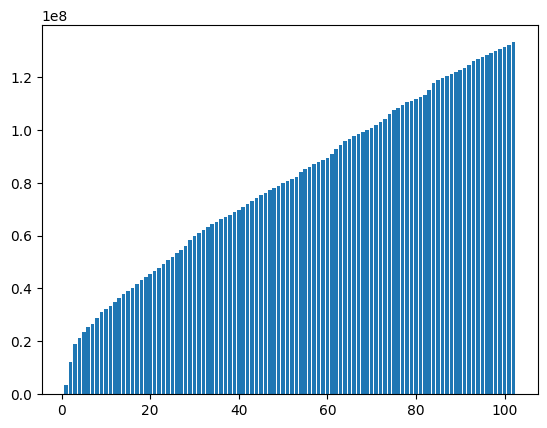

In [93]:
# plot step vs total tokens
plt.bar(df_grouped["step"], df_grouped["total_tokens"]);

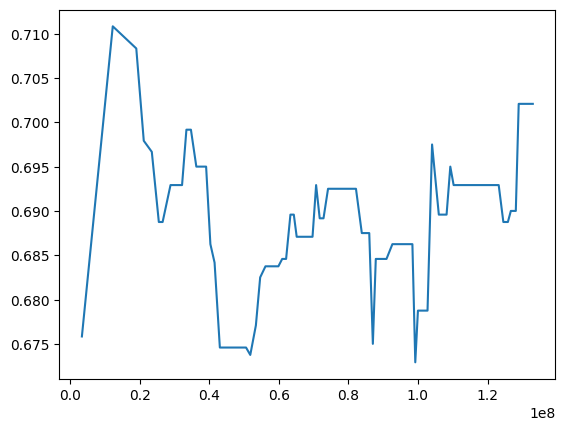

In [94]:
# plot token count vs step and adapt y-axis to min and max
column = "test_score"
plt.plot(df_grouped["total_tokens"], df_grouped[column])
plt.show();

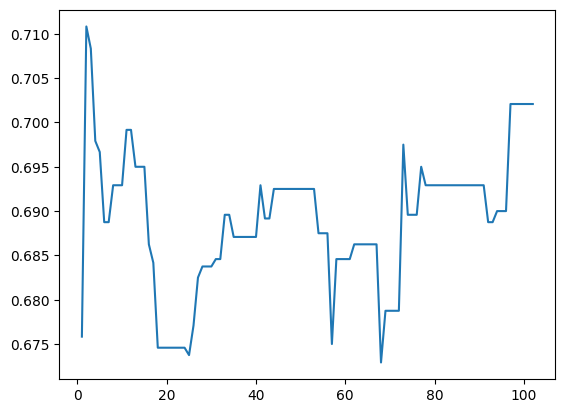

In [95]:
# plot token count vs step and adapt y-axis to min and max
column = "test_score"
plt.plot(df_grouped["step"], df_grouped[column])
plt.show();

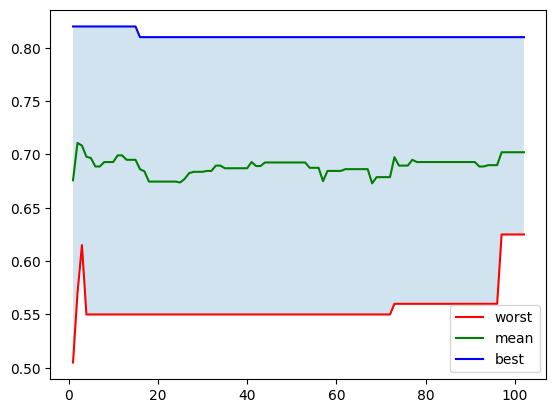

In [96]:
# x_axis => step, y_axis => worst_score, mean_score, best_score
col = "test_score"

worst_scores = df.groupby("step", as_index=False).min(numeric_only=True)[["step", col]]
mean_scores = df.groupby("step", as_index=False).mean(numeric_only=True)[["step", col]]
best_scores = df.groupby("step", as_index=False).max(numeric_only=True)[["step", col]]

plt.plot(worst_scores["step"], worst_scores[col], label="worst", color="red")
plt.plot(mean_scores["step"], mean_scores[col], label="mean", color="green")
plt.plot(best_scores["step"], best_scores[col], label="best", color="blue")
# fill area between lines
plt.fill_between(mean_scores["step"], worst_scores[col], best_scores[col], alpha=0.2)
plt.legend()
plt.show();

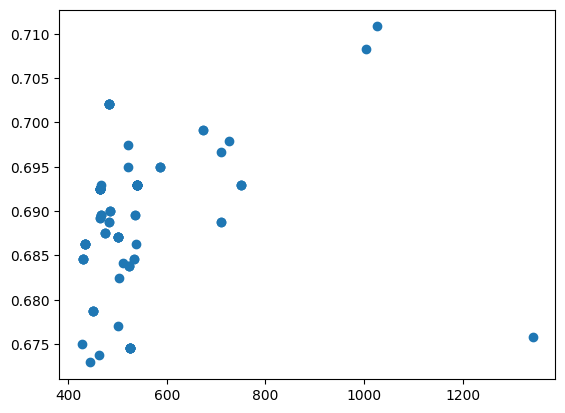

In [97]:
# plot score vs prompt length
plt.scatter(df_grouped["prompt_len"], df_grouped["test_score"])
plt.show();

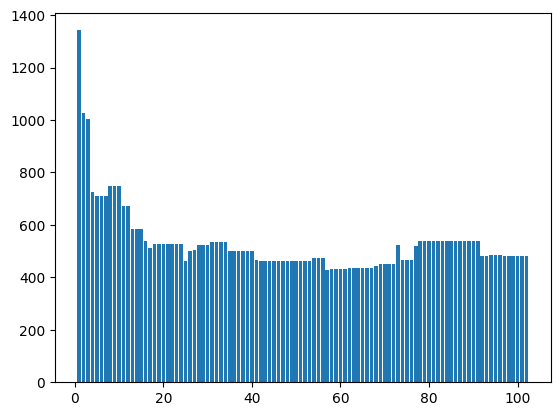

In [98]:
# prompt length vs step
plt.bar(df_grouped["step"], df_grouped["prompt_len"]);

### Analyze best prompts per step

In [99]:
df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "score")).reset_index(drop=True)
# df_best

C:\Users\tzehl\AppData\Local\Temp\ipykernel_18720\373190983.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "score")).reset_index(drop=True)


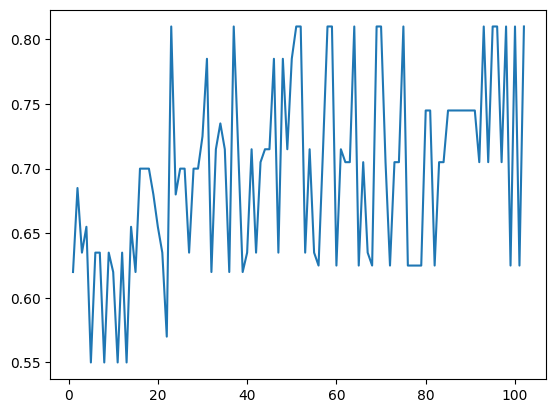

In [100]:
# max a line plot of the best score vs step
plt.plot(df_best["step"], df_best["test_score"]);

## Analyze Racing

In [101]:
from pprint import pprint as pp

p = lambda x: (pp(x.replace("\r", ""), compact=True, width=200))

In [102]:
df["test_score"].nlargest(10)

1      0.82
14     0.82
27     0.82
43     0.82
54     0.82
65     0.82
77     0.82
90     0.82
101    0.82
115    0.82
Name: test_score, dtype: float64

In [103]:
# best prompt
col = "test_score"
k_best = 1

best_prompt = df[df[col] == df[col].nlargest(k_best).values[k_best - 1]]
print("unique?", len(best_prompt["prompt"].unique()))
print("number of shots: ", best_prompt["n_shots"].values[0])
print("score: ", best_prompt[col].values[0])
print("first occurence: ", best_prompt["step"].values[0])
print("last occurence: ", best_prompt["step"].values[-1])
print("last train score: ", best_prompt["score"].values[-1].round(2))

p(best_prompt["prompt"].unique()[0])

unique? 1
number of shots:  2
score:  0.82
first occurence:  1
last occurence:  15
last train score:  0.79
('Determine the appropriate category for the following news article. Options are World, Sports, Business, and Sci/Tech. Format your response with <final_answer> category </final_answer>.\n'
 '\n'
 'Input: Tanks encircle shrine in US blitz on rebels UNITED States tanks today encircled the sacred Imam Ali shrine in the Iraqi city of Najaf, after an intense bombardment of rebel positions '
 'overnight. \n'
 'Output: <final_answer>World</final_answer>\n'
 '\n'
 'Input: UPDATE 5-Marsh  amp; McLennan CEO Jeffrey Greenberg resigns Marsh  amp; McLennan Cos. (MMC.N: Quote, Profile, Research) Chairman and Chief Executive Jeffrey Greenberg resigned on Monday, 11 '
 'days after New York Attorney General \n'
 'Output: <final_answer>Business</final_answer>\n'
 '\n'
 'Input:\n'
 '<|im_start|>assistant\n')


In [104]:
print(best_prompt["prompt"].unique()[0])

Determine the appropriate category for the following news article. Options are World, Sports, Business, and Sci/Tech. Format your response with <final_answer> category </final_answer>.

Input: Tanks encircle shrine in US blitz on rebels UNITED States tanks today encircled the sacred Imam Ali shrine in the Iraqi city of Najaf, after an intense bombardment of rebel positions overnight. 
Output: <final_answer>World</final_answer>

Input: UPDATE 5-Marsh  amp; McLennan CEO Jeffrey Greenberg resigns Marsh  amp; McLennan Cos. (MMC.N: Quote, Profile, Research) Chairman and Chief Executive Jeffrey Greenberg resigned on Monday, 11 days after New York Attorney General 
Output: <final_answer>Business</final_answer>

Input:
<|im_start|>assistant



In [105]:
best_prompt["prompt"].unique()[0]

'Determine the appropriate category for the following news article. Options are World, Sports, Business, and Sci/Tech. Format your response with <final_answer> category </final_answer>.\r\n\r\nInput: Tanks encircle shrine in US blitz on rebels UNITED States tanks today encircled the sacred Imam Ali shrine in the Iraqi city of Najaf, after an intense bombardment of rebel positions overnight. \r\nOutput: <final_answer>World</final_answer>\r\n\r\nInput: UPDATE 5-Marsh  amp; McLennan CEO Jeffrey Greenberg resigns Marsh  amp; McLennan Cos. (MMC.N: Quote, Profile, Research) Chairman and Chief Executive Jeffrey Greenberg resigned on Monday, 11 days after New York Attorney General \r\nOutput: <final_answer>Business</final_answer>\r\n\r\nInput:\r\n<|im_start|>assistant\r\n'

In [106]:
# load the prompt scores per block
path = path.replace("step_results_eval", "prompt_scores")

df_blocks = pd.read_csv(path)
# round all numbers to 2 decimal places
df_blocks = df_blocks.round(2)

df_blocks

FileNotFoundError: [Errno 2] No such file or directory: '../results/agnews/qwen/CAPO/seed43/benchmark_experiment_agnews_qwen_CAPO_43/d68fc10ed5808b22bcc05bf52807a08e381e40af3e141ec4bcd12359f96161a9/prompt_scores_QWEN_PFUSCH.csv'

In [107]:
s = df.prompt.sample(1).item()
s

"For this assignment, you'll act as a news classification assistant. Your goal is to carefully analyze the given news article and assign it to one of these four categories: World, Sports, Business, or Sci/Tech. Please format your final response as <final_answer>selected category</final_answer> to facilitate accurate system recognition and smooth processing.\r\n\r\nInput:\r\n<|im_start|>assistant\r\n"

In [108]:
df_blocks.iloc[2]["Unnamed: 0"]

'Address the math word problem by dissecting it into simpler components for easier resolution. Upon arriving at the solution, make certain that your ultimate answer is enclosed within the <final_answer> and </final_answer> markers.\r\n\r\nInput: A taco truck is selling soft tacos for $2 and hard shell tacos for $5 during the lunch rush. The first group of customers is a family that buys four hard shell tacos and three soft tacos. The rest of the customers in the lunch rush only buy two soft tacos each. There were ten customers after the family. How many dollars did the taco truck make during the lunch rush?\r\nOutput: <final_answer>66</final_answer>\r\n\r\nInput:'

In [109]:
print(s)

For this assignment, you'll act as a news classification assistant. Your goal is to carefully analyze the given news article and assign it to one of these four categories: World, Sports, Business, or Sci/Tech. Please format your final response as <final_answer>selected category</final_answer> to facilitate accurate system recognition and smooth processing.

Input:
<|im_start|>assistant



In [110]:
print("\r")

In [111]:
# get number of blocks per prompt by counting non nans per columns
n_blocks = df_blocks.count(axis=1) - 1

In [112]:
n_blocks

0       1
1       1
2      10
3      10
4       1
       ..
263     1
264     4
265     1
266    10
267     1
Length: 268, dtype: int64

In [113]:
df_count = pd.DataFrame({"n_blocks": n_blocks.values, "prompt": df_blocks["Unnamed: 0"]})

In [114]:
df_count["n_blocks"].value_counts()

n_blocks
1     199
10     32
2      20
4       7
5       4
3       4
6       1
8       1
Name: count, dtype: int64

In [115]:
# join with df
df_count = df_count.join(df.set_index("prompt"), on="prompt", how="left", lsuffix="_rrr")

# bin by test_score
df_count["test_score_bin"] = pd.cut(df_count["test_score"], bins=5)

ValueError: Bin edges must be unique: Index([nan, nan, nan, nan, nan, nan], dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [116]:
# evals vs score => boxplot
df_count.boxplot(column="n_blocks", by="test_score_bin");

KeyError: 'test_score_bin'

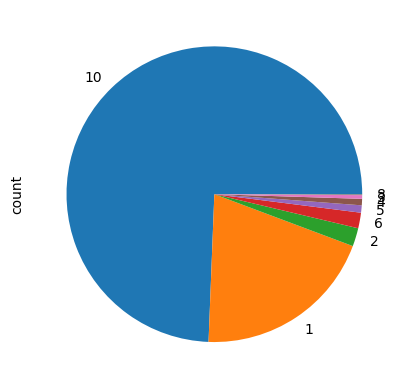

In [ ]:
# pie chart of number of blocks per prompt
df_count["n_blocks"].value_counts().plot.pie();

In [ ]:
# clculate the number of saved evaluations, so how many differ by how much from 10 in n_blocks
df_count["n_blocks_diff"] = abs(df_count["n_blocks"] - 10)
n_blocks_diff_times_n = (
    df_count["n_blocks_diff"].value_counts() * df_count["n_blocks_diff"].value_counts().index
)
n_blocks_diff_times_n.sum()

2131

In [ ]:
# total number of evaluations
df_count["n_blocks"].sum()

7859

In [ ]:
# tokens saved
(n_blocks_diff_times_n.sum()) / (n_blocks_diff_times_n.sum() + df_count["n_blocks"].sum())

0.21331331331331332

In [ ]:
df_count["n_blocks"].describe()

count    999.000000
mean       7.866867
std        3.715495
min        1.000000
25%        6.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: n_blocks, dtype: float64

In [ ]:
df

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,test_score,total_tokens,output_tokens_downstream_llm_cum,output_tokens_meta_llm_cum,input_tokens_downstream_llm_cum,input_tokens_meta_llm_cum,n_shots,prompt_len
0,1,2025-03-16 13:17:26.164321,237.770440,0.574699,Solve the given grade school math word problem...,1244,429,320898,70091,0.524,392662,70091,429,320898,1244,6,2659
1,1,2025-03-16 13:17:26.164321,237.770440,0.463391,Solve step-by-step. Final answer between <fina...,1244,429,320898,70091,0.346,785324,140182,858,641796,2488,1,325
2,1,2025-03-16 13:17:26.164321,237.770440,0.387952,Solve this math word problem using step-by-ste...,1244,429,320898,70091,0.296,1177986,210273,1287,962694,3732,3,1203
3,1,2025-03-16 13:17:26.164321,237.770440,0.374096,Solve this math problem by breaking it down in...,1244,429,320898,70091,0.386,1570648,280364,1716,1283592,4976,6,2563
4,1,2025-03-16 13:17:26.164321,237.770440,0.350665,Break down this word problem carefully. Rememb...,1244,429,320898,70091,0.344,1963310,350455,2145,1604490,6220,3,1566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,64,2025-03-16 15:10:30.586841,72.124809,0.496561,Address the provided grade school math word pr...,1700,796,79344,23203,0.450,158568932,36382112,584060,120346788,1255972,5,2171
764,64,2025-03-16 15:10:30.586841,72.124809,0.482756,Adress the given grade school math word proble...,1700,796,79344,23203,0.466,158673975,36405315,584856,120426132,1257672,2,1708
765,64,2025-03-16 15:10:30.586841,72.124809,0.457430,Solve this math problem by breaking it down in...,1700,796,79344,23203,0.386,158779018,36428518,585652,120505476,1259372,6,2563
766,64,2025-03-16 15:10:30.586841,72.124809,0.438479,Approach this mathematical challenge by dissec...,1700,796,79344,23203,0.312,158884061,36451721,586448,120584820,1261072,2,1249
